In [280]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import math
import sys
import collections
import itertools
from scipy.stats import mode
from scipy.spatial.distance import squareform
from statsmodels.tsa.stattools import adfuller

In [281]:
country_temp = pd.read_csv("https://sjoerd.tech/temperatures/GlobalLandTemperaturesByCountry.csv",sep=",",parse_dates=True) 

In [282]:
def getAvgTemp(country_data):
  arr = []
  count = []
  for i in range(0,3000):
    arr.append(0.0)
    count.append(0.0)

  for i in range(0, len(country_data)):
    date = pd.to_datetime(country_data.iloc[i][0])
    if not math.isnan(country_data.iloc[i][1]):
      arr[date.year] = arr[date.year] + country_data.iloc[i][1]
      count[date.year] = count[date.year] + 1;
  
  for i in range(0,3000):
    if count[i] > 0:
      arr[i] = arr[i] / count[i];

  data = arr[1870:2013]
  return data

In [283]:
norway_temp = getAvgTemp(country_temp[(country_temp['Country']=='Norway')])
finland_temp = getAvgTemp(country_temp[(country_temp['Country']=='Finland')])
singapore_temp = getAvgTemp(country_temp[(country_temp['Country']=='Singapore')])
cambodia_temp = getAvgTemp(country_temp[(country_temp['Country']=='Cambodia')])

Text(0.5, 0, 'Year')

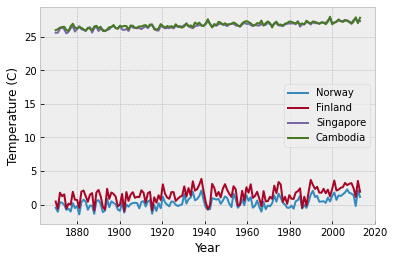

In [284]:
x = np.linspace(1870, 2013, num = 2013-1870)
fig , ax = plt.subplots()
ax.plot(x, norway_temp)
ax.plot(x, finland_temp)
ax.plot(x, singapore_temp)
ax.plot(x, cambodia_temp)
ax.legend(['Norway', 'Finland', 'Singapore', 'Cambodia'])
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Year')

*DTW* Stolen from the example code

In [285]:
plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):  
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]

In [286]:
m = KnnDtw()
print('Norway vs Finland:', m._dtw_distance(norway_temp, finland_temp))
print('Norway vs Singapore:', m._dtw_distance(norway_temp, singapore_temp))
print('Norway vs Cambodia:', m._dtw_distance(norway_temp, cambodia_temp))
print('Finland vs Singapore:', m._dtw_distance(finland_temp, singapore_temp))
print('Finland vs Cambodia:', m._dtw_distance(finland_temp, cambodia_temp))
print('Singapore vs Cambodia:', m._dtw_distance(singapore_temp, cambodia_temp))

Norway vs Finland: 118.18166666666664
Norway vs Singapore: 3759.4232500000003
Norway vs Cambodia: 3778.901916666667
Finland vs Singapore: 3591.522249999999
Finland vs Cambodia: 3611.000916666667
Singapore vs Cambodia: 21.23308333333336


4.9b

In [287]:
def getCleanedData(country_data):
  data = []
  for i in range(0, len(country_data)-1):
    date = pd.to_datetime(country_data.iloc[i][0])
    if date.year >= 1870:
      data.append(country_data.iloc[i][1])
  return data

Only pick values after 1870

In [288]:
norway_cleaned = getCleanedData(country_temp[country_temp['Country']=="Norway"])
finland_cleaned = getCleanedData(country_temp[country_temp['Country']=="Finland"])
singapore_cleaned = getCleanedData(country_temp[country_temp['Country']=="Singapore"])
cambodia_cleaned = getCleanedData(country_temp[country_temp['Country']=="Cambodia"])

In [289]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
  #Determining rolling statistics
  rolmean = pd.Series(timeseries).rolling(window=12).mean()
  rolstd = pd.Series(timeseries).rolling(window=12).std()
  x = np.linspace(1870, 2013, num = len(timeseries))

  #Plot rolling statistics:
  orig = plt.plot(x,timeseries, color='blue',label='Original')
  mean = plt.plot(x,rolmean, color='red', label='Rolling Mean')
  std = plt.plot(x,rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.show(block=False)

 #Perform Dickey-Fuller test:
  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

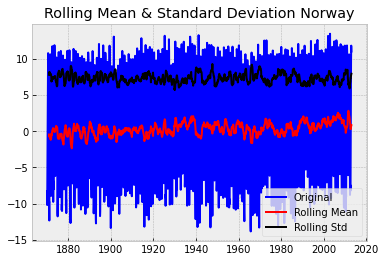

Results of Dickey-Fuller Test:
Test Statistic                   -4.460692
p-value                           0.000231
#Lags Used                       24.000000
Number of Observations Used    1699.000000
Critical Value (1%)              -3.434205
Critical Value (5%)              -2.863243
Critical Value (10%)             -2.567676
dtype: float64


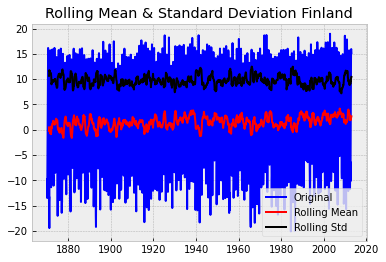

Results of Dickey-Fuller Test:
Test Statistic                   -5.629061
p-value                           0.000001
#Lags Used                       24.000000
Number of Observations Used    1699.000000
Critical Value (1%)              -3.434205
Critical Value (5%)              -2.863243
Critical Value (10%)             -2.567676
dtype: float64


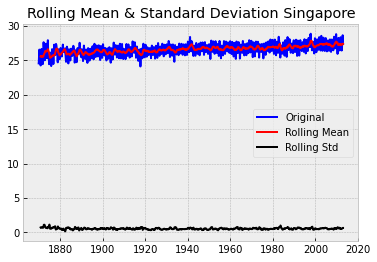

Results of Dickey-Fuller Test:
Test Statistic                   -3.407675
p-value                           0.010700
#Lags Used                       25.000000
Number of Observations Used    1698.000000
Critical Value (1%)              -3.434207
Critical Value (5%)              -2.863244
Critical Value (10%)             -2.567677
dtype: float64


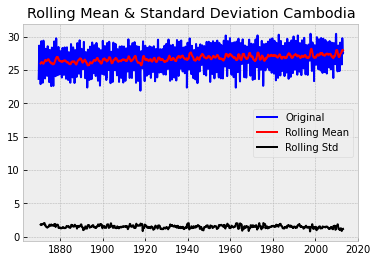

Results of Dickey-Fuller Test:
Test Statistic                   -3.986411
p-value                           0.001483
#Lags Used                       25.000000
Number of Observations Used    1698.000000
Critical Value (1%)              -3.434207
Critical Value (5%)              -2.863244
Critical Value (10%)             -2.567677
dtype: float64


In [290]:
#Conduct test on the 'raw' data per country  
plt.title('Rolling Mean & Standard Deviation Norway')
test_stationarity(norway_cleaned)
plt.title('Rolling Mean & Standard Deviation Finland')
test_stationarity(finland_cleaned)
plt.title('Rolling Mean & Standard Deviation Singapore')
test_stationarity(singapore_cleaned)
plt.title('Rolling Mean & Standard Deviation Cambodia')
test_stationarity(cambodia_cleaned)

4.9c Eliminating Trend and Seasonality

In [296]:
from statsmodels.tsa.seasonal import seasonal_decompose
def trendAndSeasonality(country_data):
  country_log = np.log(country_data)
  country_log = pd.DataFrame(country_log).dropna().to_numpy().flatten()
  country_log_diff = country_log - np.roll(country_log, shift = 1)
  x = np.linspace(1870, 2013, len(country_log_diff))
  # plt.plot(x,country_log_diff)
  # plt.show()
  # test_stationarity(country_log_diff)
  # plt.show()
  
  decomposition = seasonal_decompose(country_log, freq = 12)
  plt.show()
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.subplot(411)
  plt.plot(country_log, label='Original')
  plt.legend(loc='best')
  plt.subplot(412)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(413)
  plt.plot(seasonal,label='Seasonality')
  plt.legend(loc='best')
  plt.subplot(414)
  plt.plot(residual, label='Residuals')
  plt.legend(loc='best')
  plt.tight_layout()
  plt.show()

  ts_log_decompose = pd.DataFrame(residual)
  ts_log_decompose.dropna(inplace=True)
  #ts_log_decompose = ts_log_decompose[np.logical_not(np.isnan(x))]
  numpy_arr = ts_log_decompose.to_numpy().flatten()
  test_stationarity(numpy_arr)
  #return pd.DataFrame(residual).dropna().to_numpy().flatten()

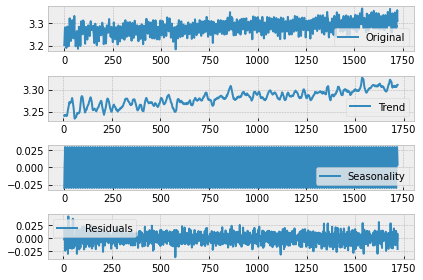

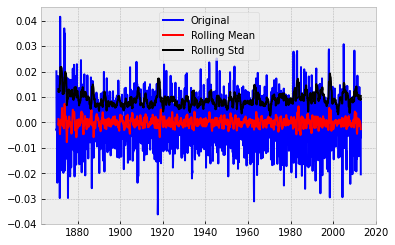

Results of Dickey-Fuller Test:
Test Statistic                -1.469152e+01
p-value                        3.044181e-27
#Lags Used                     2.500000e+01
Number of Observations Used    1.686000e+03
Critical Value (1%)           -3.434235e+00
Critical Value (5%)           -2.863256e+00
Critical Value (10%)          -2.567683e+00
dtype: float64


In [300]:
trendAndSeasonality(singapore_cleaned)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


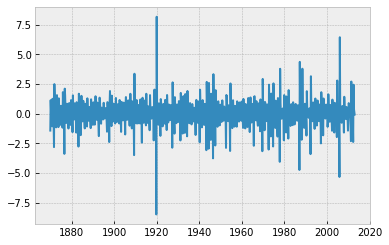

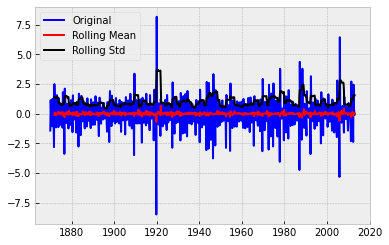

Results of Dickey-Fuller Test:
Test Statistic                -1.325051e+01
p-value                        8.795578e-25
#Lags Used                     1.300000e+01
Number of Observations Used    8.080000e+02
Critical Value (1%)           -3.438469e+00
Critical Value (5%)           -2.865124e+00
Critical Value (10%)          -2.568678e+00
dtype: float64


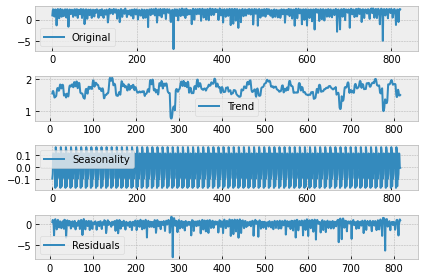

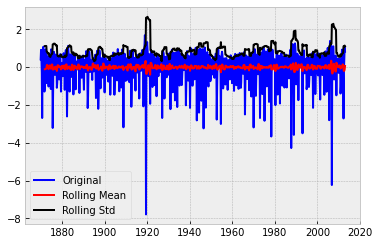

Results of Dickey-Fuller Test:
Test Statistic                -1.186715e+01
p-value                        6.634197e-22
#Lags Used                     2.100000e+01
Number of Observations Used    7.880000e+02
Critical Value (1%)           -3.438676e+00
Critical Value (5%)           -2.865215e+00
Critical Value (10%)          -2.568727e+00
dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


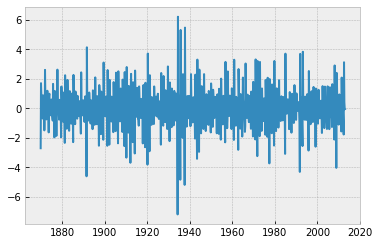

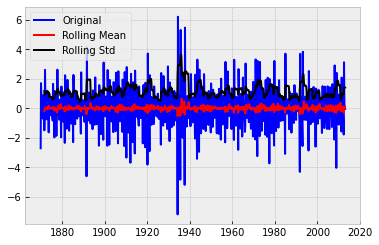

Results of Dickey-Fuller Test:
Test Statistic                -1.124337e+01
p-value                        1.784263e-20
#Lags Used                     2.100000e+01
Number of Observations Used    8.880000e+02
Critical Value (1%)           -3.437735e+00
Critical Value (5%)           -2.864800e+00
Critical Value (10%)          -2.568506e+00
dtype: float64


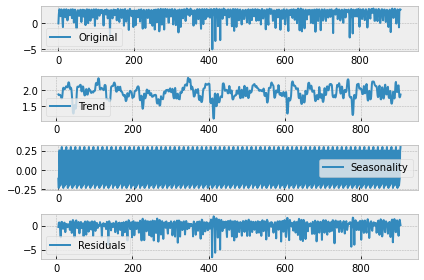

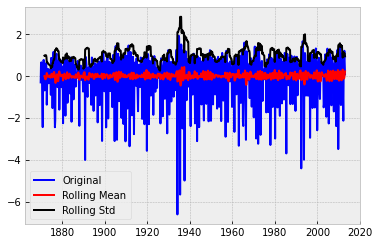

Results of Dickey-Fuller Test:
Test Statistic                -1.304985e+01
p-value                        2.153380e-24
#Lags Used                     2.100000e+01
Number of Observations Used    8.760000e+02
Critical Value (1%)           -3.437837e+00
Critical Value (5%)           -2.864845e+00
Critical Value (10%)          -2.568530e+00
dtype: float64


TypeError: ignored

In [293]:
m = KnnDtw()
print('Norway vs Finland:', m._dtw_distance(trendAndSeasonality(norway_cleaned), trendAndSeasonality(finland_cleaned)))
print('Norway vs Singapore:', m._dtw_distance(trendAndSeasonality(norway_cleaned), trendAndSeasonality(singapore_cleaned)))
print('Norway vs Cambodia:', m._dtw_distance(trendAndSeasonality(norway_cleaned), trendAndSeasonality(cambodia_cleaned)))
print('Finland vs Singapore:', m._dtw_distance(trendAndSeasonality(finland_cleaned), trendAndSeasonality(singapore_cleaned)))
print('Finland vs Cambodia:', m._dtw_distance(trendAndSeasonality(finland_cleaned), trendAndSeasonality(cambodia_cleaned)))
print('Singapore vs Cambodia:', m._dtw_distance(trendAndSeasonality(singapore_cleaned), trendAndSeasonality(cambodia_cleaned)))

4.9d

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


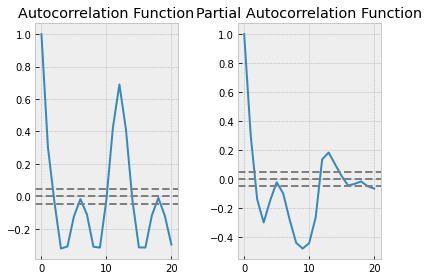

In [301]:
from statsmodels.tsa.stattools import acf, pacf
country_data = cambodia_cleaned
ts_log = np.log(country_data)
ts_log = pd.DataFrame(ts_log).dropna().to_numpy().flatten()
ts_log_diff = ts_log - np.roll(ts_log, shift = 1)
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
  
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

AR

Text(0.5, 1.0, 'RSS: 1.4917')

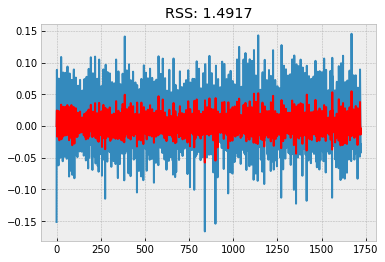

In [303]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0)) #2,1,0  start_params = [0,2]
results_AR = model.fit(disp=-1)
ts_log_diff_ = ts_log_diff[0:len(ts_log_diff)-1]
plt.plot(ts_log_diff_)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff_)**2))

MA

Text(0.5, 1.0, 'RSS: 1.3520')

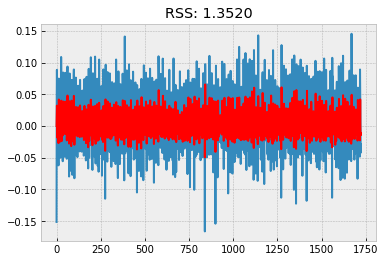

In [304]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(start_params = [2,0], disp=-1)  
ts_log_diff_ = ts_log_diff[0:len(ts_log_diff)-1]
plt.plot(ts_log_diff_)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff_)**2))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RSS: 18.3696')

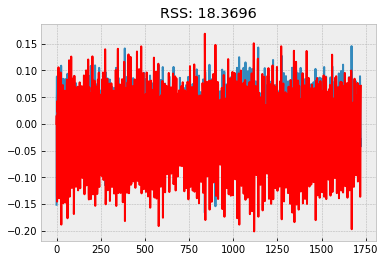

In [308]:
model = ARIMA(ts_log, order=(2,1,0))  
results_ARIMA = model.fit(start_params = [2,2], disp=-2)  # start_params = [2,2]
ts_log_diff_ = ts_log_diff[0:len(ts_log_diff)-1]
plt.plot(ts_log_diff_)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff_)**2))

0       0.000088
1       0.015412
2      -0.134334
3      -0.145331
4      -0.031270
          ...   
1718   -0.136316
1719   -0.052469
1720    0.005649
1721    0.053034
1722    0.071176
Length: 1723, dtype: float64
0       0.000088
1       0.015501
2      -0.118833
3      -0.264164
4      -0.295434
          ...   
1718    0.114496
1719    0.062027
1720    0.067676
1721    0.120710
1722    0.191886
Length: 1723, dtype: float64
REAL VALUES
[28.237, 29.609, 29.766, 29.45, 28.236, 27.434, 27.516]
PREDICTED VALUES
[30.39700209 26.52342392 25.16764875 25.3102285  26.68875723 28.65757891
 23.654     ]


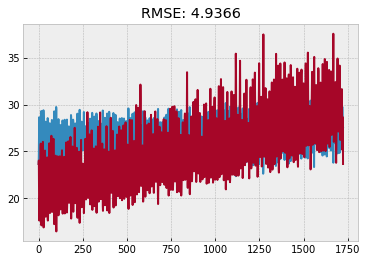

In [307]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

ts_log_pd = pd.Series(ts_log)
predictions_ARIMA_log = pd.Series(ts_log_pd.iloc[0], index=ts_log_pd.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(cambodia_cleaned)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-cambodia_cleaned)**2)/len(cambodia_cleaned)))

print('REAL VALUES')
print(cambodia_cleaned[len(cambodia_cleaned)-7:len(cambodia_cleaned)])
print('PREDICTED VALUES')
print(predictions_ARIMA.to_numpy()[len(predictions_ARIMA)-7:len(predictions_ARIMA)])

In [ ]:
np.exp(results_ARIMA.forecast(steps = 7)[0])